In [62]:
import dadrah.analysis.root_plotting_util as rpu
import dadrah.util.run_paths as runpa
import dadrah.util.string_constants as stco
import dadrah.selection.selection_util as seut
import pofah.jet_sample as js
import pofah.phase_space.cut_constants as cuts

import pathlib
import argparse
import scipy
from scipy.stats import kstwo
from scipy.stats import chi2

import numpy as np
import ROOT as rt
import root_numpy as rtnp
import uuid
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import root_numpy as rtnp
import mplhep as hep
plt.style.use(hep.style.ROOT)
import cmsstyle #mplhep for Python2 cheatsheet

In [63]:
scipy.__version__

'1.5.1'

## runtime params

### change:

In [64]:
poly_cut = False
xsecs_sig   = [0,20,40,60,80,100] # signal cross sections
ae_run_n = 113
#qr_run_n, qr_model_str = 4, 'poly'
#qr_run_n, qr_model_str = 5, 'bernstein'
#qr_run_n, qr_model_str, train_share = 8, 'dense_70pct_train', 0.7
#qr_run_n, qr_model_str, train_share = 9, 'dense_50pct_train', 0.5
#qr_run_n, qr_model_str, train_share = 7, 'dense_polyfit', 0.2
qr_run_n, qr_model_str, train_share = 31, 'dense_kfold', 0
file_name_root_hist = 'histograms_injSig_PDinj_NA3p5_r'+str(qr_run_n)+'.root'
#quants = [0.0, 0.3, 0.5, 0.7, 0.9, 0.99]
quants = [0.0, 0.3, 0.5, 0.7, 0.9]
#quants = [0.0, 0.7]
quants_inv = [round((1.-q),2) for q in quants] # invert quantiles to [1.0 0.9, 0.7, 0.5, 0.3, 0.1, 0.01]

In [65]:
xsec_train = 0 # signal cross section used when training the QR
mX = 3.5
sample_id_qcd = 'qcdSigAllTest'+str(int((1-train_share)*100))+'pct' if train_share else 'qcdSigAll'
sample_id_sig = 'GtoWW35naReco'
sample_ids = [sample_id_qcd, sample_id_sig]
template_q_idx = 0
quant_tmplt = quants[template_q_idx]

In [66]:
if poly_cut:
    paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections_poly_cut'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
    path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_id_sig[:-4], 'xsec': str(int(xsec_train)), 'loss': 'rk5_05', 'order':'5'}
else:
    paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
    path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_id_sig, 'xsec': str(int(xsec_train)), 'loss': 'rk5_05'}
paths.extend_in_path_data(path_ext_dict)
paths.extend_out_path_data({**path_ext_dict, 'hypothesis_testing': None})

### fixed

In [67]:
# Rescaling the inputs to lumi
qcd_xsec         = 8730000.0 # Crossection in fb             
qcd_gen_events   = 134366091.0+199435365.0+90490645.0+134264102.0 #(all generated QCD)
sig_xsec_default = 10. #In units of fb (10 fb == 0.01 pb) 
sig_gen_events   = 972050.0 #(all generated signal)
lumi             = qcd_gen_events/qcd_xsec # assuming 64/fb since qcd_gen_events/8730000 ~ 64

scale_qcd = qcd_xsec*lumi/qcd_gen_events
scale_sig = (1-train_share)*sig_xsec_default*lumi/sig_gen_events #X% already used for quantile regression, must be removed
print('Usign luminosity {}'.format(lumi))
print('Scale QCD with {}'.format(scale_qcd))
print('Scale signal with {}'.format(scale_sig))

Usign luminosity 63.98123745704467
Scale QCD with 1.0
Scale signal with 0.0006582093252100682


In [68]:
# efficiencies
quants_tmp = np.asarray(quants+[1.])
effs = (quants_tmp)[template_q_idx+1:] - (quants_tmp)[template_q_idx:-1]
effs = effs[1:]/effs[0] # scale down instead of up (apply to template quantile)

In [69]:
effs

array([0.6667, 0.6667, 0.6667, 0.3333])

In [127]:
n_bins = 35
min_mjj = 1600.
max_mjj = 5400.
expo_binning = False
dijet_binning = True


if dijet_binning:
    bin_edges = np.array([1200, 1255, 1320, 1387, 1457, 1529, 1604, 1681, 1761, 1844, 1930, 2019, 
                          2111, 2206, 2305, 2406, 2512, 2620, 2733, 2849, 2969, 3093, 3221, 3353,
                          3490, 3632, 3778, 3928, 4084, 4245, 4411, 4583, 4760, 4943, 5132, 5327]).astype('float')
    bin_edges = bin_edges[bin_edges>min_mjj]
elif expo_binning:
    x_shift = 3
    lin_bins = np.linspace(0.,1.,n_bins)
    exp_bins = lin_bins/(np.exp(-lin_bins+x_shift)/np.exp(x_shift-1))
    bin_edges = exp_bins*(max_mjj-min_mjj)+min_mjj
    
else: # simple linear binning
    bin_edges = np.array(np.linspace(min_mjj, max_mjj, n_bins).tolist()).astype('float') #100 GeV binning. Stop at 5600! Fit fails if going to 6800
    
n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

In [128]:
bin_edges

array([1604., 1681., 1761., 1844., 1930., 2019., 2111., 2206., 2305.,
       2406., 2512., 2620., 2733., 2849., 2969., 3093., 3221., 3353.,
       3490., 3632., 3778., 3928., 4084., 4245., 4411., 4583., 4760.,
       4943., 5132., 5327.])

## read histogram data

In [129]:
def read_root_hist_data(file_name):
    
    hist_data = {}
    ff = rt.TFile.Open(file_name,'r')

    # read bins from template quantile
    dat = ff.Get('data_acc_{}fb_q{}p'.format(0,int(100))); dat.SetDirectory(0);
    bin_centers = np.asarray([dat.GetXaxis().GetBinCenter(j) for j in range(1,dat.GetNbinsX()+1)])

    # for each quantile
    for i, quant in enumerate(quants):

        hist_data_quant = {}
        q_key = quants_inv[i]*100

        # for each signal injection
        for xsec in xsecs_sig:

            dat = ff.Get('data_acc_{}fb_q{}p'.format(xsec,int(q_key))); dat.SetDirectory(0);
            yy = np.asarray([dat.GetBinContent(j) for j in range(1,dat.GetNbinsX()+1)])

            hist_data_quant[xsec] = yy

        hist_data[quant] = hist_data_quant
        
    return bin_centers, hist_data

In [130]:
def read_raw_selection_data(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, paths):
    samples = {}

    for sample_id in sample_ids:
        samples[sample_id] = js.JetSample.from_input_file(sample_id, paths.in_file_path(sample_id), **cuts.signalregion_cuts)
        
    # qcd raw data
    samples_ortho_quantiles_qcd = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_qcd], quantiles[1:])
    mjj_vals_qcd = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_qcd]
    # signal raw data
    samples_ortho_quantiles_sig = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_sig], quantiles[1:])
    mjj_vals_sig = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_sig]
    
    return mjj_vals_qcd, mjj_vals_sig

In [131]:
def read_raw_selection_data_to_numpy_hist(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, bin_edges, paths):
    
    mjj_vals_qcd, mjj_vals_sig = read_raw_selection_data(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, paths)
    
    datas_qcd = {}
    datas_sig = {}
    
    # qcd histogram data
    for mjj, q in zip(mjj_vals_qcd[template_q_idx:], quantiles[template_q_idx:]):
        counts, _, _ = plt.hist(mjj, bins=bin_edges)
        datas_qcd[q] = counts
        
    # sig histogram data
    for mjj, q in zip(mjj_vals_sig[template_q_idx:], quantiles[template_q_idx:]):
        counts, _, _ = plt.hist(mjj, bins=bin_edges)
        datas_sig[q] = counts
    
    # make signal injection dataset for all signal xsecs
    histos_data_inj = {}
    
     # for each quantile
    for quant in quantiles[template_q_idx:]:
        
        histos_data_inj_quant = {}
        
        # for each signal cross section (each signal injection value)
        for xsec in xsecs_sig:
        
            # get qcd data
            dat = datas_qcd[quant]
            # add signal data according to cross section
            scale_xsec_sig = xsec/sig_xsec_default
            sig_inj = datas_sig[quant]*scale_sig*scale_xsec_sig
            # TODO: sample sig bin height from poisson?
            
            histos_data_inj_quant[xsec] = dat + sig_inj
            
        histos_data_inj[quant] = histos_data_inj_quant
            
    return bin_edges[:-1], histos_data_inj     
    

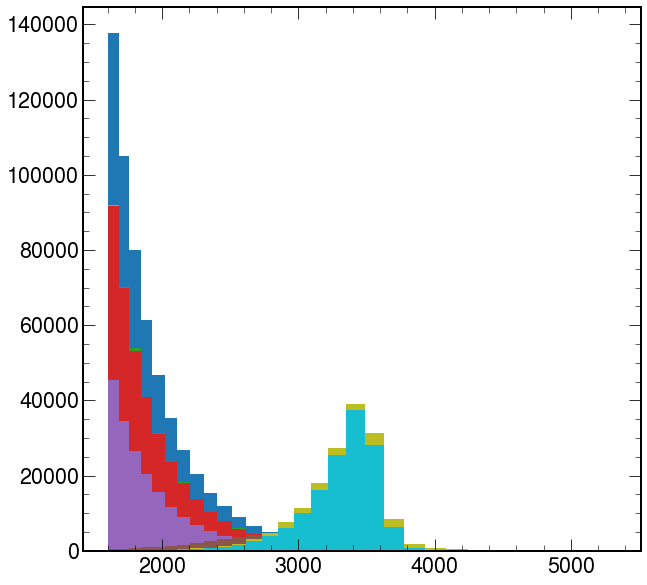

In [132]:
#bin_centers, hist_data = read_root_hist_data(file_name_root_hist)
bin_centers, hist_data = read_raw_selection_data_to_numpy_hist(quants, ae_run_n, qr_run_n, sample_id_sig, xsec_train, bin_edges, paths)

In [133]:
quants

[0.0, 0.3, 0.5, 0.7, 0.9]

## plot histograms

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc10-opt/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


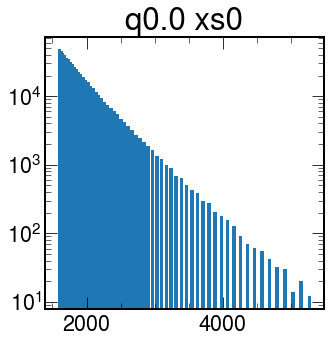

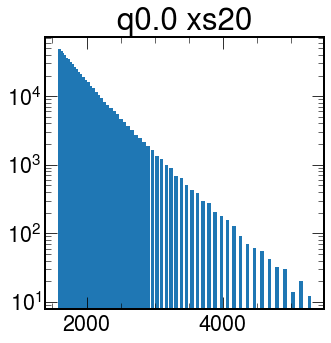

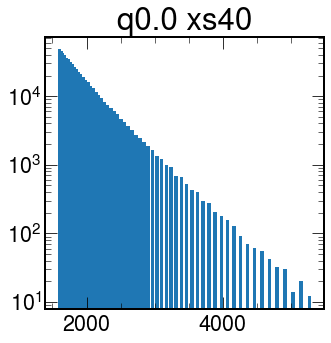

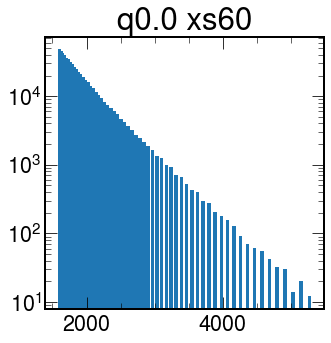

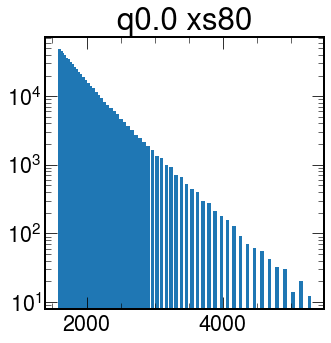

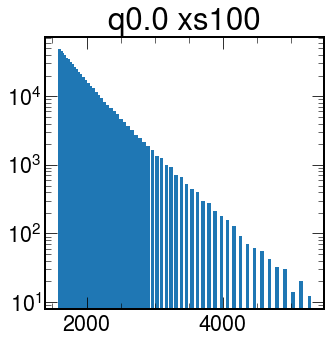

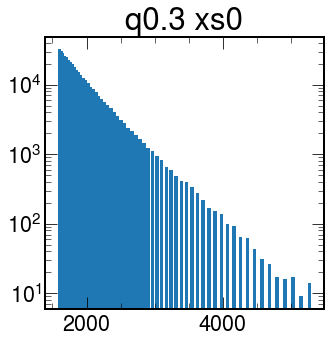

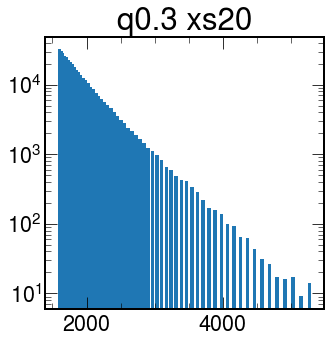

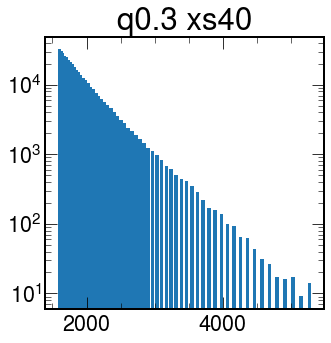

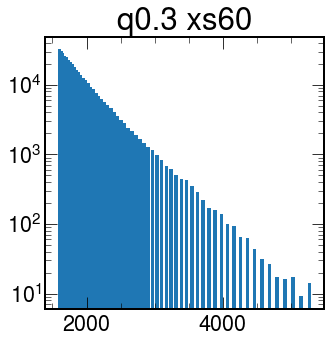

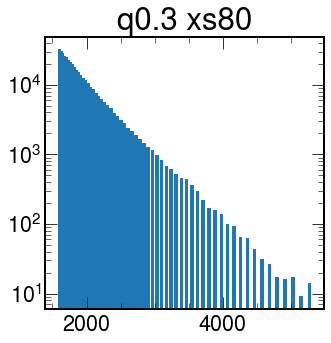

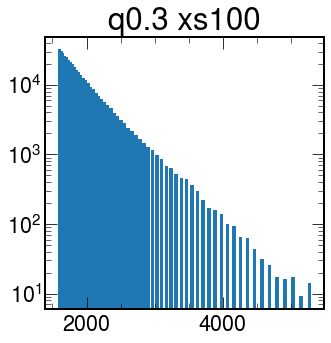

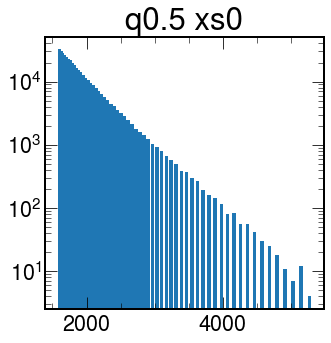

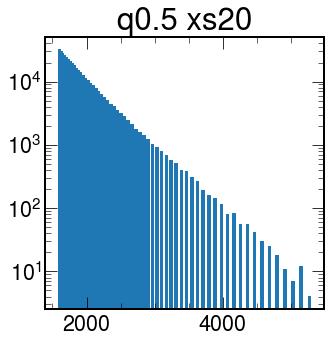

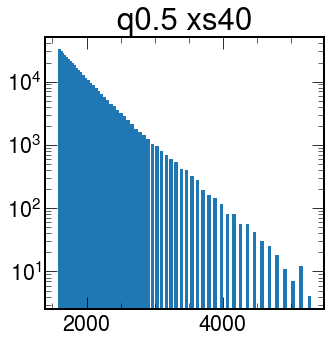

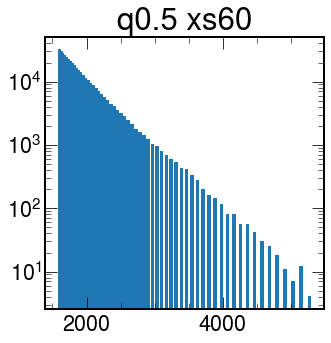

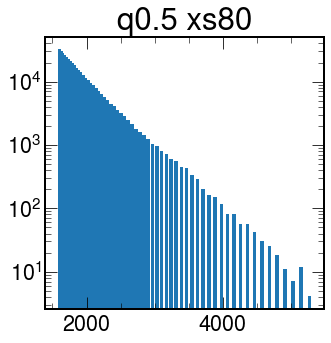

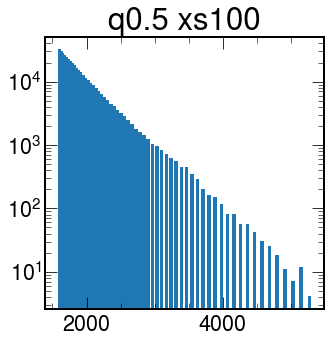

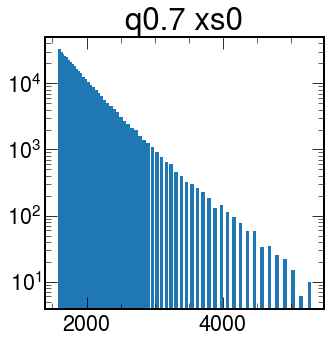

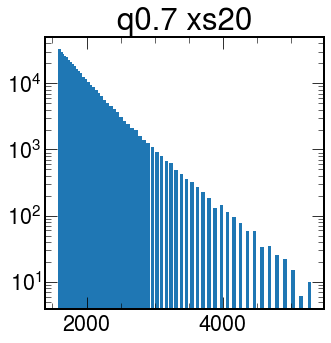

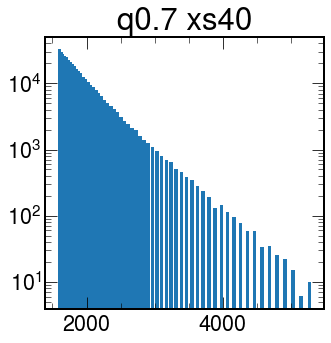

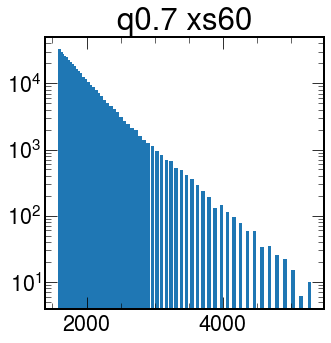

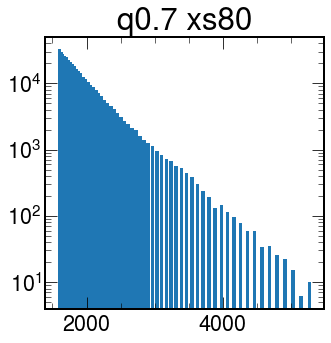

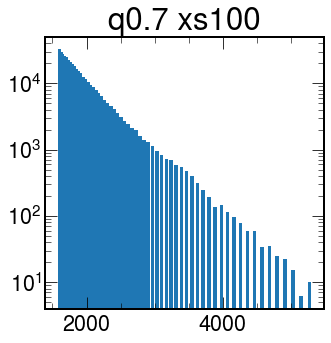

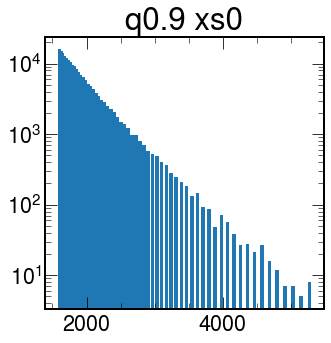

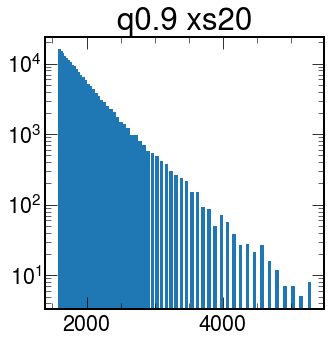

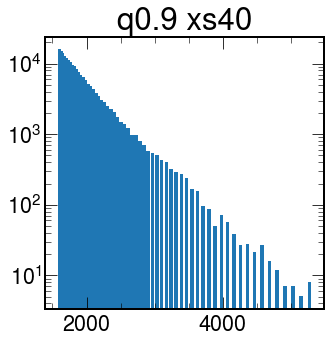

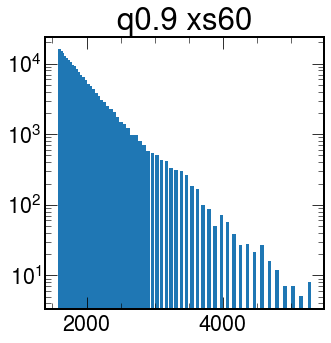

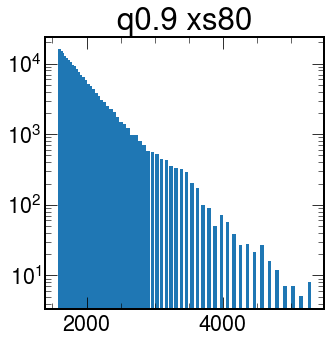

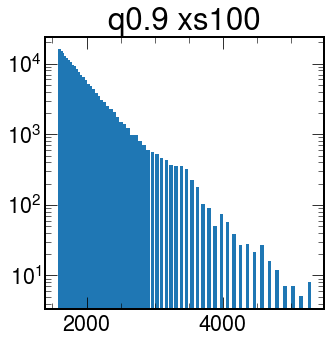

In [77]:
for quant in quants[template_q_idx:]:
    for xsec in xsecs_sig:
        yy = hist_data[quant][xsec]
        plt.figure(figsize=(5, 5))
        plt.bar(bin_centers, yy, width=50, log=True)
        plt.title('q{} xs{}'.format(quant, xsec))

In [78]:
# print N samples
for quant in quants[template_q_idx:]:
    for xsec in xsecs_sig:
        yy = hist_data[quant][xsec]
        print('quant {:>4}, xsec {:>3}: {:>8} events'.format(quant, xsec, int(sum(yy))))

quant  0.0, xsec   0:   583737 events
quant  0.0, xsec  20:   583825 events
quant  0.0, xsec  40:   583914 events
quant  0.0, xsec  60:   584002 events
quant  0.0, xsec  80:   584091 events
quant  0.0, xsec 100:   584179 events
quant  0.3, xsec   0:   388604 events
quant  0.3, xsec  20:   388690 events
quant  0.3, xsec  40:   388776 events
quant  0.3, xsec  60:   388863 events
quant  0.3, xsec  80:   388949 events
quant  0.3, xsec 100:   389036 events
quant  0.5, xsec   0:   390507 events
quant  0.5, xsec  20:   390625 events
quant  0.5, xsec  40:   390743 events
quant  0.5, xsec  60:   390861 events
quant  0.5, xsec  80:   390979 events
quant  0.5, xsec 100:   391097 events
quant  0.7, xsec   0:   389212 events
quant  0.7, xsec  20:   389423 events
quant  0.7, xsec  40:   389635 events
quant  0.7, xsec  60:   389847 events
quant  0.7, xsec  80:   390058 events
quant  0.7, xsec 100:   390270 events
quant  0.9, xsec   0:   193520 events
quant  0.9, xsec  20:   193708 events
quant  0.9, 

# Chi Square tests

In [134]:
def chi_square_pearson(observed, expected):
    statistics_per_bin = [(o-e)**2/e for o, e in zip(observed, expected)]
    return sum(statistics_per_bin), statistics_per_bin

In [135]:
def chi_square_neyman(observed, expected):
    statistics_per_bin = [(o-e)**2/max(o,1) for o, e in zip(observed, expected)] # adapted to zero bin counts
    return sum(statistics_per_bin), statistics_per_bin

In [136]:
def chi_square_poisson_likeli(observed, expected):
    statistics_per_bin = [2*(e - o + (o * np.log(o/e) if o else 0)) for o, e in zip(observed, expected)]
    return sum(statistics_per_bin), statistics_per_bin

In [137]:
np.set_printoptions(precision=4, suppress=False)

In [138]:
df = n_bins - 1 # degrees of freedom = number of measurements (=bins) - 1

chi_sq_pearson_stats = {}
chi_sq_neyman_stats = {}
chi_sq_poisson_like = {}

for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    test_stat_xsecs_p = []
    pvals_p = []
    test_stat_xsecs_n = []
    pvals_n = []
    test_stat_xsecs_l = []
    pvals_l = []
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        t_p, _ = chi_square_pearson(observed, expected)
        pval_p = 1 - chi2.cdf(t_p, df=df)
        t_n, _ = chi_square_neyman(observed, expected)
        pval_n = 1 - chi2.cdf(t_n, df=df)
        t_l, _ = chi_square_poisson_likeli(observed, expected)
        pval_l = 1 - chi2.cdf(t_l, df=df)
        test_stat_xsecs_p.append(t_p)
        test_stat_xsecs_n.append(t_n)
        test_stat_xsecs_l.append(t_l)
        pvals_p.append(pval_p)
        pvals_n.append(pval_n)
        pvals_l.append(pval_l)
    
    print('pearson for quantile', quant_test)
    print('ch2:' , np.array(test_stat_xsecs_p))
    print('p-val: ', np.array(pvals_p))
    print('neyman for quantile', quant_test)
    print(np.array(test_stat_xsecs_n))
    print('p-val: ', np.array(pvals_n))
    print('likelihood for quantile', quant_test)
    print(np.array(test_stat_xsecs_l))
    print('p-val: ', np.array(pvals_l))
    print('\n')
    
    chi_sq_pearson_stats[quant_test] = test_stat_xsecs_p
    chi_sq_neyman_stats[quant_test] = test_stat_xsecs_n
    chi_sq_poisson_like[quant_test] = test_stat_xsecs_l

pearson for quantile 0.3
ch2: [64.8228 69.0572 73.8297 79.1279 84.9401 91.2548]
p-val:  [9.5177e-05 2.5178e-05 5.3360e-06 8.9956e-07 1.1997e-07 1.2609e-08]
neyman for quantile 0.3
[60.4408 63.9923 67.9735 72.3635 77.1431 82.2942]
p-val:  [3.5765e-04 1.2285e-04 3.5542e-05 8.6424e-06 1.7643e-06 3.0244e-07]
likelihood for quantile 0.3
[63.2248 67.2114 71.6952 76.6605 82.0924 87.9765]
p-val:  [1.5525e-04 4.5212e-05 1.0750e-05 2.0758e-06 3.2437e-07 4.0927e-08]


pearson for quantile 0.5
ch2: [48.7025 50.4851 54.4533 60.5567 68.7468 78.9766]
p-val:  [8.9930e-03 5.7067e-03 1.9769e-03 3.4560e-04 2.7799e-05 9.4721e-07]
neyman for quantile 0.5
[52.3335 53.4312 56.5226 61.4509 68.0763 76.2742]
p-val:  [3.5103e-03 2.6132e-03 1.1103e-03 2.6493e-04 3.4403e-05 2.3636e-06]
likelihood for quantile 0.5
[49.6048 51.1509 54.8083 60.4878 68.1062 77.5855]
p-val:  [7.1563e-03 4.7982e-03 1.7926e-03 3.5271e-04 3.4078e-05 1.5194e-06]


pearson for quantile 0.7
ch2: [ 42.2123  48.6594  68.1667 100.4282 145.1481 

### draw test statistics on chi-square distribution graph

saving fig to  fig/vae_run_113/qr_run_31/sig_GtoWW35naReco/xsec_0/loss_rk5_05/hypothesis_testing/chi_square_Pearson.png
saving fig to  fig/vae_run_113/qr_run_31/sig_GtoWW35naReco/xsec_0/loss_rk5_05/hypothesis_testing/chi_square_Neyman.png
saving fig to  fig/vae_run_113/qr_run_31/sig_GtoWW35naReco/xsec_0/loss_rk5_05/hypothesis_testing/chi_square_Poisson Like.png


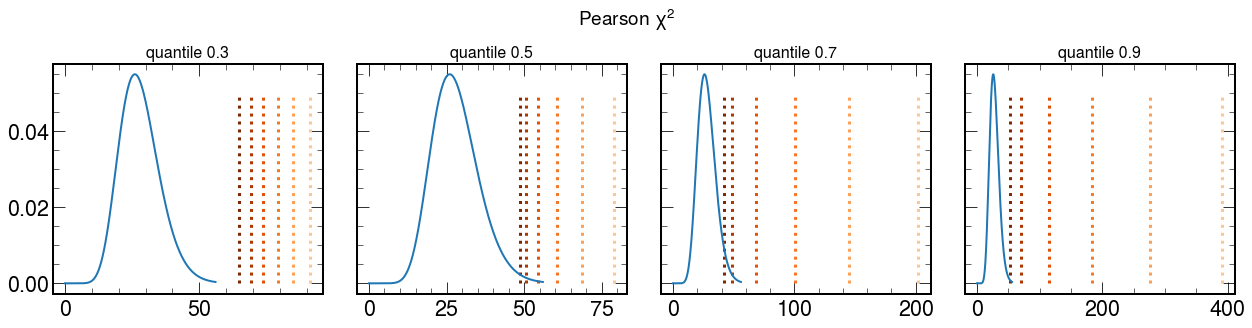

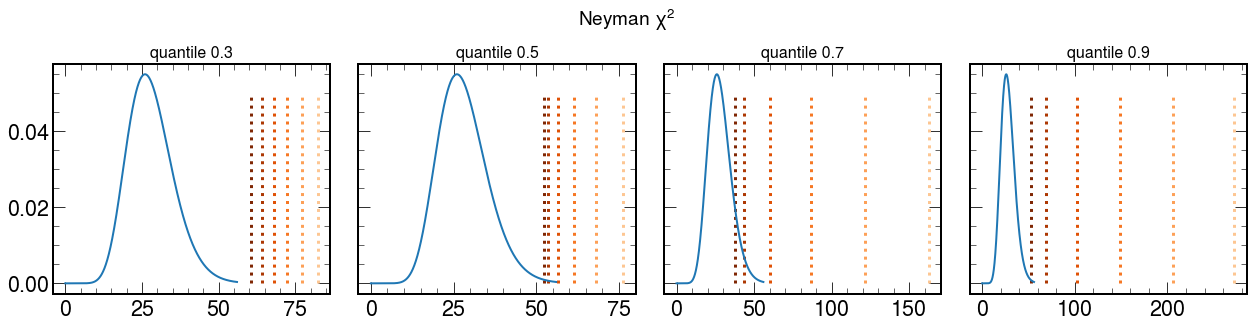

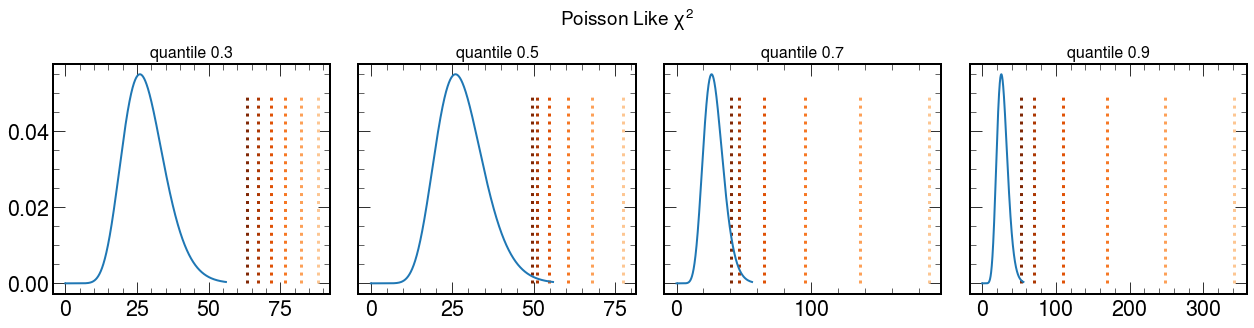

In [139]:
chi_sq_results = {
    'Pearson': chi_sq_pearson_stats,
    'Neyman' : chi_sq_neyman_stats,
    'Poisson Like': chi_sq_poisson_like
}

x = np.arange(0, df*2, 0.001)
cmap = cm.get_cmap('Oranges')
cmap = cmap(np.linspace(0.0, 1.0, len(xsecs_sig)+2))[::-1]

for method, val_dict in chi_sq_results.items():
    fig, axs = plt.subplots(1,len(quants)-1,sharey=True,figsize=(18,5))
    for quant, ax in zip(quants[template_q_idx+1:],axs.flat):
        chi_sq_vals = val_dict[quant]
        ax.plot(x, chi2.pdf(x, df=df), lw=2) # df = num-observed - 1
        ax.vlines(chi_sq_vals,colors=cmap,ymin=0,ymax=0.05, ls=':',lw=3)
        ax.set_title('quantile {}'.format(quant), fontsize=16)
    fig.suptitle(r'{} $\chi^2$'.format(method), fontsize=19)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_path = os.path.join(paths.out_data_dir,'chi_square_{}.png'.format(method))
    print('saving fig to ', fig_path)
    plt.savefig(fig_path)

In [140]:
for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    test_stat_xsecs_p = []
    test_stat_xsecs_n = []
    for xsec in [xsecs_sig[0]]:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        print('\nquant ' +str(quant_test)+', xsec '+ str(xsec))
        print('obs')
        print(np.array(observed))
        print('total events ' + str(sum(observed)))
        print('exp')
        print(np.array(expected))


quant 0.3, xsec 0
obs
[9.1933e+04 6.9935e+04 5.3285e+04 4.0287e+04 3.1001e+04 2.3263e+04
 1.7860e+04 1.3631e+04 1.0451e+04 7.8860e+03 5.8800e+03 4.4520e+03
 3.3850e+03 2.5180e+03 1.9480e+03 1.4040e+03 1.0420e+03 7.7600e+02
 6.1500e+02 4.2600e+02 2.9500e+02 2.4300e+02 1.5700e+02 1.1300e+02
 7.4000e+01 4.7000e+01 3.0000e+01 2.7000e+01 1.8000e+01]
total events 382982.0
exp
[9.1810e+04 7.0094e+04 5.3281e+04 4.0891e+04 3.1125e+04 2.3577e+04
 1.7885e+04 1.3641e+04 1.0220e+04 8.0060e+03 5.9187e+03 4.4387e+03
 3.2980e+03 2.5493e+03 1.8580e+03 1.3547e+03 1.0633e+03 7.3933e+02
 5.2867e+02 3.9800e+02 3.0600e+02 1.9933e+02 1.5933e+02 1.0000e+02
 6.3333e+01 5.6000e+01 3.3333e+01 2.2667e+01 1.6667e+01]

quant 0.5, xsec 0
obs
[9.1794e+04 7.0127e+04 5.4061e+04 4.0733e+04 3.1242e+04 2.3734e+04
 1.8213e+04 1.3740e+04 1.0221e+04 8.0340e+03 5.9590e+03 4.4940e+03
 3.2200e+03 2.4930e+03 1.8530e+03 1.3880e+03 1.0110e+03 7.1800e+02
 5.8200e+02 4.0600e+02 2.6800e+02 2.0500e+02 1.4400e+02 9.0000e+01
 7.2000e+0

In [141]:
dat_tmplt = hist_data[quant_tmplt]

In [142]:
for quant, eff in zip(quants[template_q_idx+1:], effs):
    dat = hist_data[quant]
    p_vals = [scipy.stats.chisquare(f_obs=dat[xsec], f_exp=dat_tmplt[xsec]*eff, axis=0).pvalue for xsec in xsecs_sig]
    print('pvals for quantile {}'.format(quant))
    print(xsecs_sig)
    print(np.asarray(p_vals))

pvals for quantile 0.3
[0, 20, 40, 60, 80, 100]
[9.5177e-05 2.5178e-05 5.3360e-06 8.9956e-07 1.1997e-07 1.2609e-08]
pvals for quantile 0.5
[0, 20, 40, 60, 80, 100]
[8.9930e-03 5.7067e-03 1.9769e-03 3.4560e-04 2.7799e-05 9.4721e-07]
pvals for quantile 0.7
[0, 20, 40, 60, 80, 100]
[4.1402e-02 9.0907e-03 3.3431e-05 4.3159e-10 9.1530e-18 2.8163e-28]
pvals for quantile 0.9
[0, 20, 40, 60, 80, 100]
[3.1767e-03 1.3626e-05 1.9871e-12 1.1739e-24 1.9479e-42 1.1838e-65]


In [143]:
quant_test = 0.3
xsec = 0
eff = effs[quants.index(quant_test)-1]#0.2/0.3 # 30% bottom quantile vs 20% 0.7-0.9 quantile

In [144]:
n_bins

29

In [145]:
eff

0.6666666666666667

In [146]:
# observed
obs = hist_data[quant_test][xsec]

In [147]:
# expected
expt = hist_data[quant_tmplt][xsec]*eff

In [148]:
statistic = 0
for e, o in zip(hist_data[quant_tmplt][xsec]*eff, hist_data[quant_test][xsec]):
    print('obs {}, exp {}, stat {}'.format(o,e,(o-e)**2/e))
    statistic += (o-e)**2/e

obs 91933.0, exp 91810.00000000001, stat 0.1647859710270822
obs 69935.0, exp 70094.00000000001, stat 0.36067281079699576
obs 53285.0, exp 53281.333333333336, stat 0.0002523293544535921
obs 40287.0, exp 40891.333333333336, stat 8.931447033057879
obs 31001.0, exp 31124.66666666667, stat 0.4913609070334025
obs 23263.0, exp 23576.666666666668, stat 4.173057165747711
obs 17860.0, exp 17884.666666666668, stat 0.03402045203216
obs 13631.0, exp 13640.666666666668, stat 0.006850430901065531
obs 10451.0, exp 10220.000000000002, stat 5.221232876712246
obs 7886.0, exp 8006.000000000001, stat 1.798651011741221
obs 5880.0, exp 5918.666666666667, stat 0.2526094465720547
obs 4452.0, exp 4438.666666666667, stat 0.04005206768799257
obs 3385.0, exp 3298.0000000000005, stat 2.295027289266198
obs 2518.0, exp 2549.3333333333335, stat 0.3851115760111613
obs 1948.0, exp 1858.0000000000002, stat 4.359526372443465
obs 1404.0, exp 1354.6666666666667, stat 1.7965879265091806
obs 1042.0, exp 1063.3333333333335, st

In [149]:
statistic

64.82284595252685

In [150]:
scipy.stats.chisquare(f_obs=hist_data[quant_test][xsec], f_exp=hist_data[quant_tmplt][xsec]*eff, axis=0)

Power_divergenceResult(statistic=64.82284595252685, pvalue=9.51768193538639e-05)

Text(0.5, 1.0, 'dense_kfold model, 0.0-0.3 template quantile')

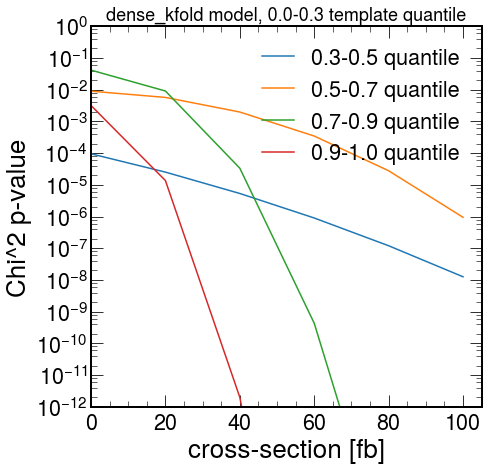

In [151]:
fig = plt.figure(figsize=(7, 7)) # figsize=(5, 5)
# Load CMS style sheet
plt.style.use(hep.style.CMS)
# define color palett for pvalue plotting
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                    '#bcbd22', '#17becf']    


for quant, eff, c in zip(quants[template_q_idx+1:], effs, palette):
    
    dat = hist_data[quant]
    p_vals = [scipy.stats.chisquare(f_obs=dat[xsec], f_exp=dat_tmplt[xsec]*eff, axis=0).pvalue for xsec in xsecs_sig]
        
    label = '{}-{} quantile'.format((quants+['1.0'])[quants.index(quant)], (quants+['1.0'])[quants.index(quant)+1])
    plt.semilogy(xsecs_sig, p_vals, color=c, label=label)
    
plt.legend(loc='best')
plt.xlabel('cross-section [fb]')
plt.ylabel('Chi^2 p-value')
plt.ylim(bottom=1e-12, top=1)
plt.xlim(left=0)

# set yticks manually
plt.gca().tick_params(direction='in', which='both')
plt.gca().minorticks_on()
locmaj = mpl.ticker.LogLocator(base=10, numticks=15) 
plt.gca().yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2,0.4,0.6,0.8), numticks=15)
plt.gca().yaxis.set_minor_locator(locmin)
plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

plt.title('{} model, {}-{} template quantile'.format(qr_model_str,quants[template_q_idx],quants[template_q_idx+1]), fontsize=18)

    #plt.title('{} model, {}-{} template q, {}-{:.2f} test q {} binning'.format(qr_model_str,quants_inv[template_q_idx+1],quants_inv[template_q_idx], (quants_inv+['0.0'])[quants.index(quant)+1], (quants_inv+['0.0'])[quants.index(quant)], 'dijet' if dijet_binning else 'linear' ))

## Kolmogorov-Smirnov 2-sample test

In [97]:
# empirical CDF
def ecdf(pdf):
    cdf = np.cumsum(pdf)
    return cdf / cdf[-1]

In [98]:
def kolmogorov_smirnov(observed, expected):
    obs_cdf = ecdf(observed)
    exp_cdf = ecdf(expected)
    return max(abs(obs_cdf-exp_cdf))

In [99]:
def pval_ks(ks_t, n, m):
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    en = m * n / (m + n)
    return kstwo.sf(ks_t, np.round(en))

In [100]:
ks_stats = {}

for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    test_stat_xsecs_ks = []
    pvals_ks = []
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        n, m = float(np.sum(observed)), float(np.sum(expected))
        t_ks = kolmogorov_smirnov(observed, expected)
        p_ks = pval_ks(t_ks, n, m)
        
        test_stat_xsecs_ks.append(t_ks)
        pvals_ks.append(p_ks)
    
    print('KS for quantile', quant_test)
    print('t:' , np.array(test_stat_xsecs_ks))
    print('p-val: ', np.array(pvals_ks))
    print('\n')
    
    ks_stats[quant_test] = test_stat_xsecs_ks

KS for quantile 0.3
t: [0.0017 0.0018 0.0019 0.0019 0.002  0.0021]
p-val:  [0.612  0.5583 0.5063 0.4565 0.4094 0.3653]


KS for quantile 0.5
t: [0.0013 0.0013 0.0014 0.0015 0.0015 0.0016]
p-val:  [0.9122 0.8785 0.84   0.7975 0.7521 0.7048]


KS for quantile 0.7
t: [0.0016 0.0019 0.0022 0.0025 0.0028 0.0031]
p-val:  [0.7249 0.5052 0.3194 0.1835 0.095  0.0454]


KS for quantile 0.9
t: [0.003  0.0034 0.0038 0.0043 0.0047 0.0051]
p-val:  [0.3562 0.2095 0.1144 0.0581 0.0275 0.0121]




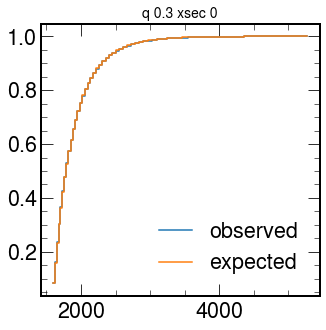

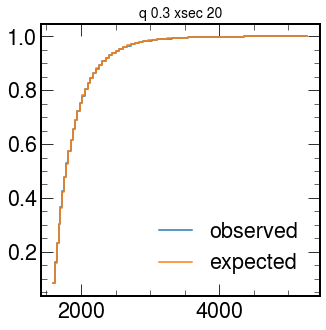

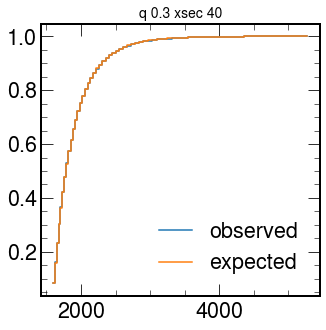

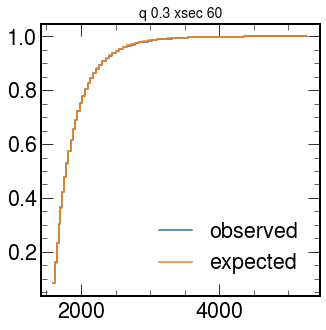

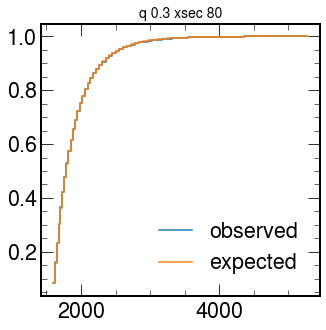

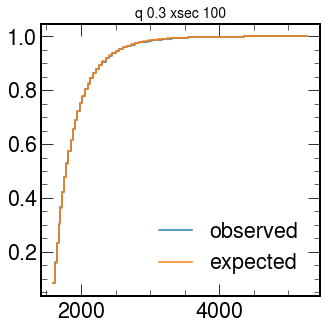

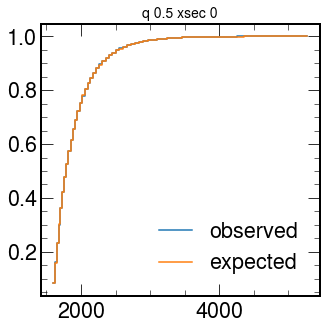

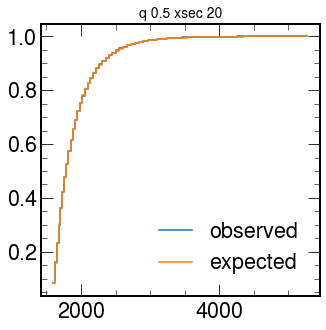

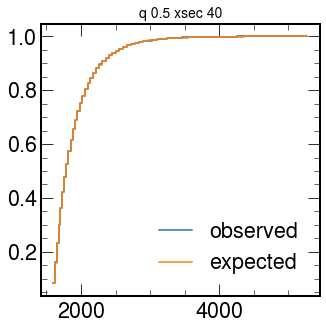

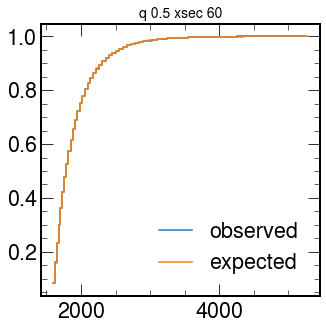

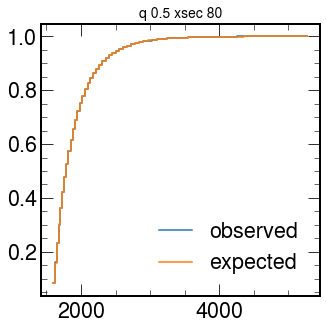

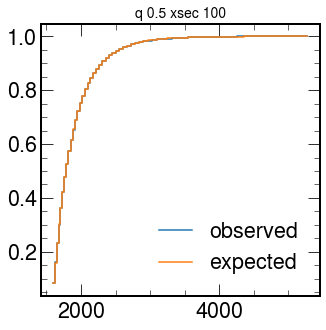

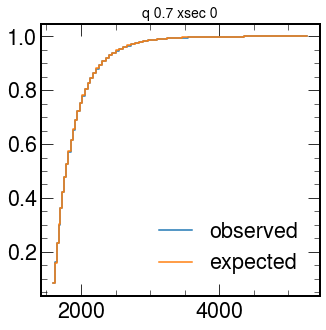

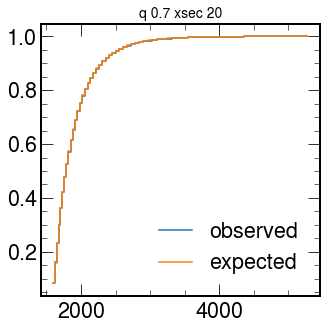

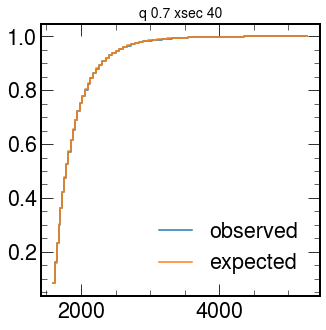

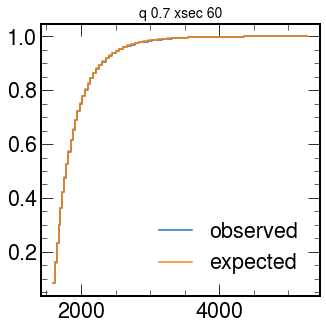

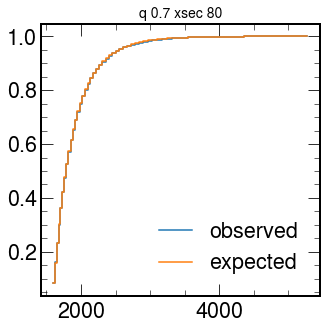

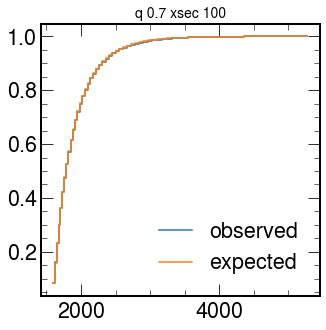

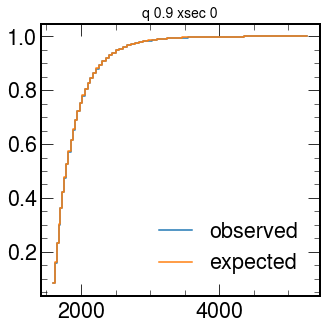

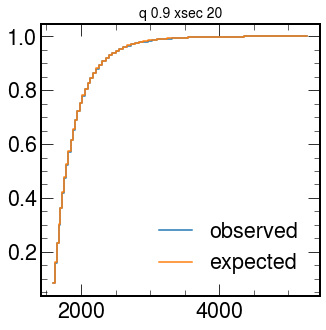

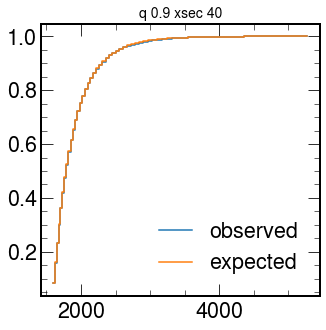

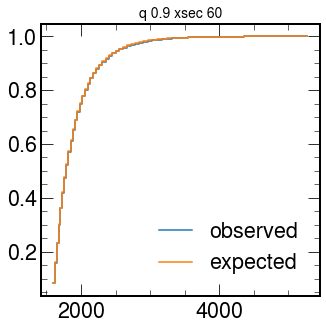

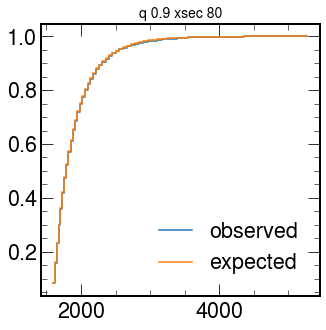

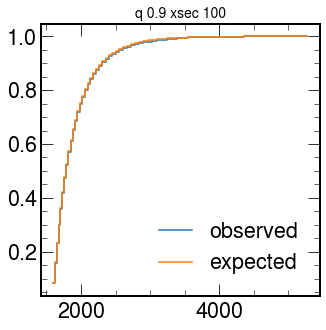

In [101]:
for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        obs_ecdf = ecdf(observed)
        exp_ecdf = ecdf(expected)
        
        fig = plt.figure(figsize=(5,5))
        plt.plot(bin_edges[:-1], obs_ecdf, label='observed', drawstyle='steps-post')
        plt.plot(bin_edges[:-1], exp_ecdf, label='expected', drawstyle='steps-post')
        plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
        plt.legend(loc='best')
        plt.show()


## KS from pdfs

In [102]:
mjj_vals_qcd, mjj_vals_sig = read_raw_selection_data(quants, ae_run_n, qr_run_n, sample_id_sig, xsec_train, paths)

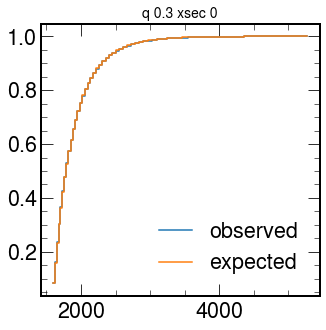

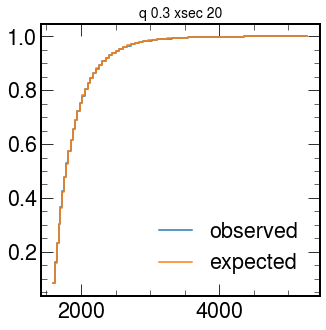

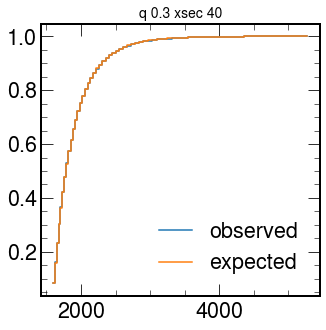

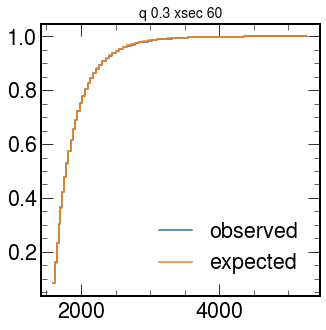

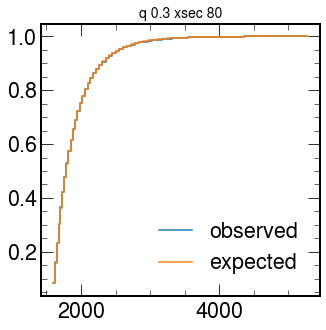

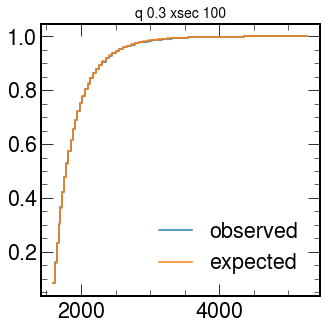

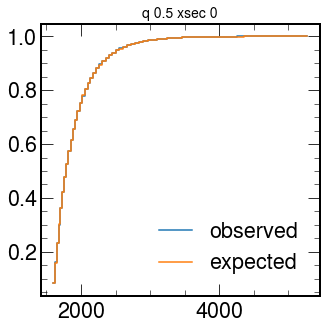

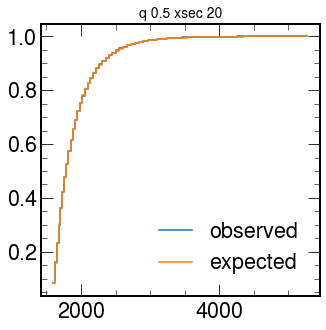

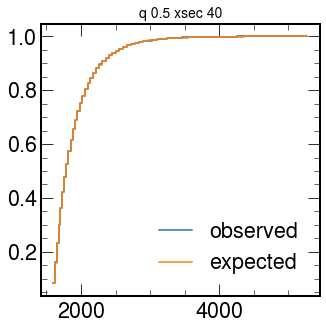

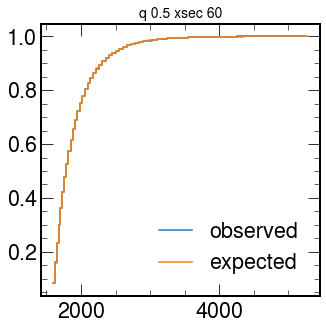

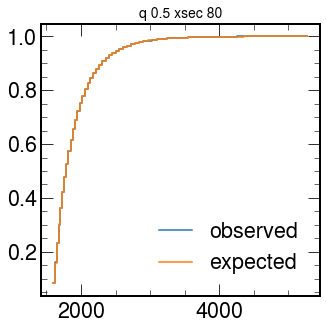

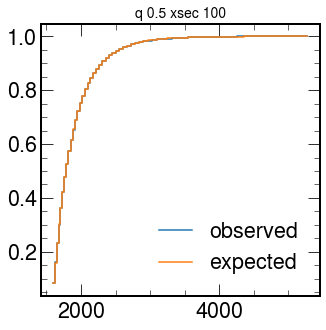

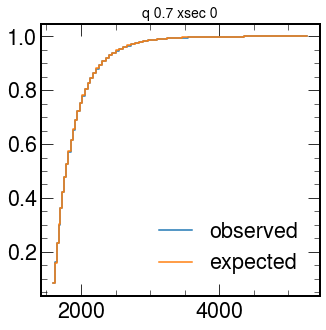

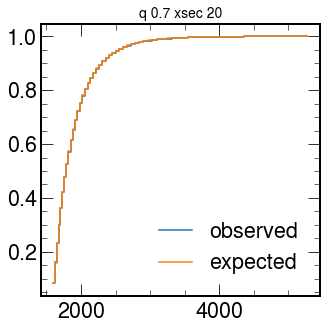

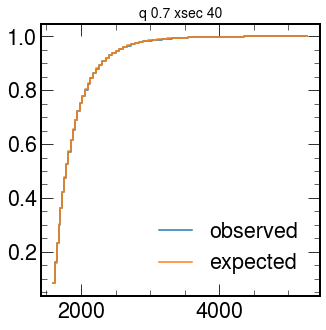

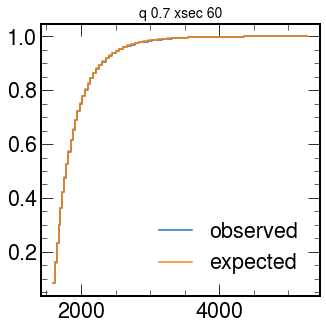

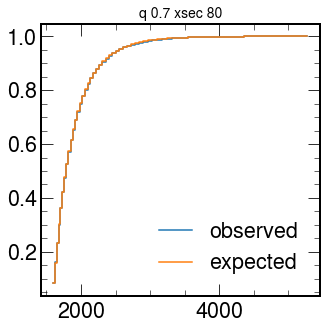

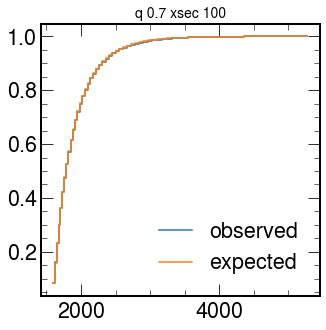

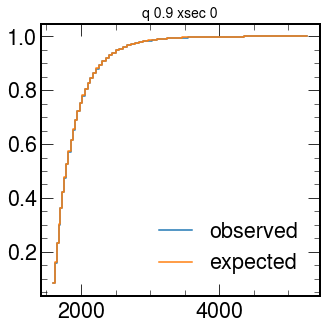

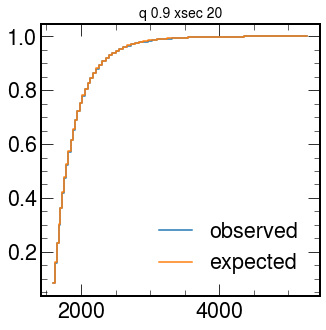

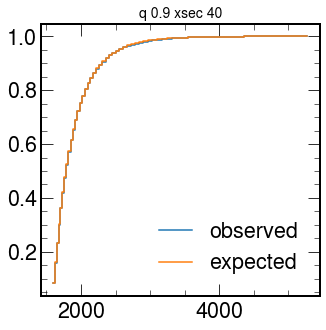

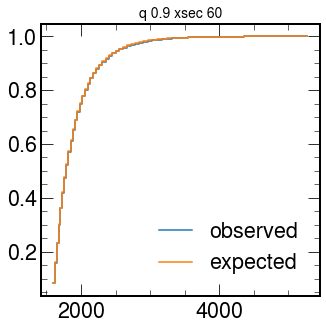

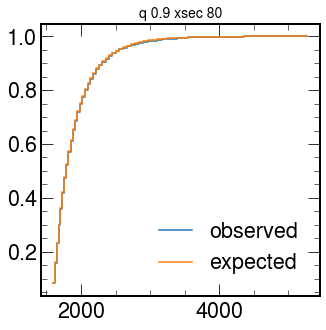

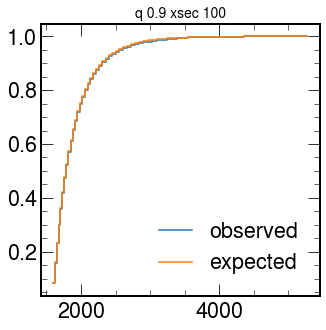

In [103]:
for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        obs_ecdf = ecdf(observed)
        exp_ecdf = ecdf(expected)
        
        fig = plt.figure(figsize=(5,5))
        plt.plot(bin_edges[:-1], obs_ecdf, label='observed', drawstyle='steps-post')
        plt.plot(bin_edges[:-1], exp_ecdf, label='expected', drawstyle='steps-post')
        plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
        plt.legend(loc='best')
        plt.show()


In [104]:
len(mjj_vals_sig)

5

In [105]:
def get_ks_test_stat_pval(data1, data2):
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    data_all = np.concatenate([data1, data2])
    # using searchsorted solves equal data problem
    cdf1 = np.searchsorted(data1, data_all, side='right') / n1
    cdf2 = np.searchsorted(data2, data_all, side='right') / n2
    t_ks = np.max(np.abs(cdf1 - cdf2))
    m, n = sorted([float(n1), float(n2)], reverse=True)
    en = m * n / (m + n)
    prob = kstwo.sf(t_ks, np.round(en))
    return t_ks, prob

In [106]:
def get_ks_test_stat_pval_from_cdf(cdf1, cdf2, n1, n2):
    t_ks = np.max(np.abs(cdf1 - cdf2))
    m, n = sorted([float(n1), float(n2)], reverse=True)
    en = m * n / (m + n)
    prob = kstwo.sf(t_ks, np.round(en))
    return t_ks, prob

In [107]:
s1 = np.random.normal(size=100000)
s2 = np.random.normal(size=100000)

In [108]:
from scipy import stats
stats.ks_2samp(s1, s2)

KstestResult(statistic=0.005240000000000022, pvalue=0.12791714203607774)

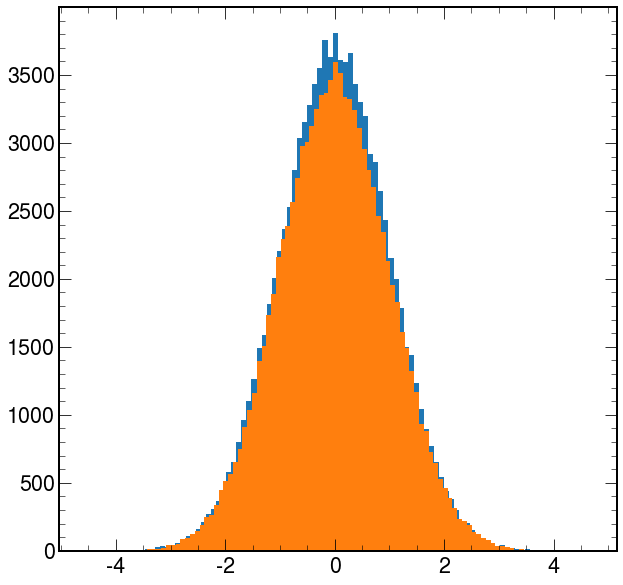

In [109]:
counts1, _, _ = plt.hist(s1, bins=100)
counts2, _, _ = plt.hist(s2, bins=100)
n1, n2 = float(len(s1)), float(len(s2))
cdf1 = np.cumsum(counts1)
cdf1 = cdf1 / cdf1[-1]
cdf2 = np.cumsum(counts2)
cdf2 = cdf2 / cdf2[-1]
t_ks, p_ks = get_ks_test_stat_pval_from_cdf(cdf1, cdf2, n1, n2)

In [110]:
print(t_ks, p_ks)

0.019959999999999978 9.804678461650754e-18


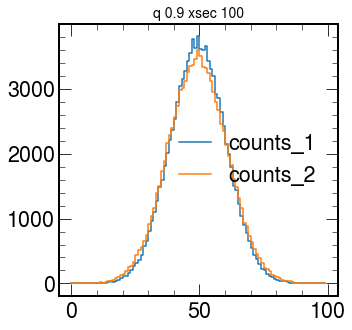

In [111]:
fig = plt.figure(figsize=(5,5))
plt.plot(counts1, label='counts_1', drawstyle='steps-post')
plt.plot(counts2, label='counts_2', drawstyle='steps-post')
plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
plt.legend(loc='best')
plt.show()

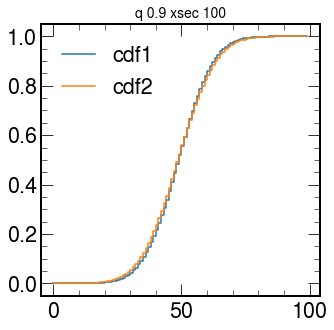

In [112]:
fig = plt.figure(figsize=(5,5))
plt.plot(cdf1, label='cdf1', drawstyle='steps-post')
plt.plot(cdf2, label='cdf2', drawstyle='steps-post')
plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
plt.legend(loc='best')
plt.show()

In [113]:
s1 = np.random.normal(loc=1, size=10000)
s2 = np.random.normal(loc=2, size=100)

In [114]:
stats.ks_2samp(s1, s2)

KstestResult(statistic=0.3497, pvalue=2.5341950760093823e-11)

In [115]:
s1 = np.random.normal(scale=1, size=10000)
s2 = np.random.normal(scale=2, size=100)
stats.ks_2samp(s1, s2)

KstestResult(statistic=0.1873, pvalue=0.0016353699052019666)

# Goodness of Fit

In [116]:
import scipy as sci

def poisson_log_likelihood(bin_h_obs, bin_h_exp): # bin_h_exp must be already scaled to efficiency
    like = sci.stats.poisson.pmf(k=bin_h_obs, mu=bin_h_exp)
    return np.sum(-np.log(like)) # calculating negative log like (the smaller p, the larger -log like => test for right tail)

In [117]:
poisson_log_likelihood(obs, expt)

316.52172387947746

In [118]:
-np.log(sci.stats.poisson.pmf(k=obs, mu=expt))

array([6.5297, 6.5009, 6.077 , 7.0608, 7.5897, 7.1514, 5.9173, 6.7266,
       6.9918, 8.8067, 6.5451, 5.7194, 7.1106, 5.6159, 5.8461, 5.6076,
       6.0489, 5.3978, 7.487 , 5.6591, 7.6147, 6.7524, 5.8409, 5.5466,
       5.7676, 4.9922, 5.1292, 4.8143, 4.9155, 5.1724, 4.8701, 4.5885,
       4.5927, 5.4711, 7.1763, 4.2896, 4.165 , 4.1512, 4.7531, 4.1059,
       9.3298, 8.06  , 4.5116, 4.7354, 4.3185, 4.4478, 4.4891, 3.2573,
       3.4636, 3.0896, 5.8049, 2.8672, 3.101 , 2.6244, 2.8138, 2.7401,
       4.8673, 2.8228, 4.079 ])

In [119]:
# check likelihood distribution from toys

toy_likes = []
for i in range(int(1e5)):
    # take expected bin heights as mu
    toy = sci.stats.poisson.rvs(expt)
    toy_like = poisson_log_likelihood(toy, expt)
    toy_likes.append(toy_like)
    

In [120]:
len(toy_likes)

100000

In [121]:
np.mean(toy_likes)

293.07232873160416

(array([4.000e+00, 6.000e+00, 4.000e+00, 8.000e+00, 1.500e+01, 2.600e+01,
        3.500e+01, 5.900e+01, 9.400e+01, 1.410e+02, 1.770e+02, 2.490e+02,
        3.490e+02, 4.650e+02, 5.960e+02, 7.570e+02, 8.610e+02, 1.077e+03,
        1.304e+03, 1.553e+03, 1.782e+03, 2.051e+03, 2.240e+03, 2.546e+03,
        2.805e+03, 2.996e+03, 3.186e+03, 3.393e+03, 3.554e+03, 3.658e+03,
        3.821e+03, 3.835e+03, 3.855e+03, 3.797e+03, 3.676e+03, 3.656e+03,
        3.535e+03, 3.424e+03, 3.232e+03, 3.151e+03, 2.838e+03, 2.705e+03,
        2.527e+03, 2.330e+03, 2.083e+03, 1.817e+03, 1.761e+03, 1.600e+03,
        1.446e+03, 1.226e+03, 1.163e+03, 9.550e+02, 8.410e+02, 7.620e+02,
        5.900e+02, 5.700e+02, 4.350e+02, 3.770e+02, 3.340e+02, 2.850e+02,
        2.120e+02, 1.980e+02, 1.770e+02, 1.550e+02, 1.230e+02, 9.900e+01,
        8.000e+01, 6.900e+01, 5.600e+01, 3.700e+01, 3.600e+01, 3.300e+01,
        1.900e+01, 1.900e+01, 1.700e+01, 1.100e+01, 9.000e+00, 8.000e+00,
        5.000e+00, 3.000e+00, 5.000e+0

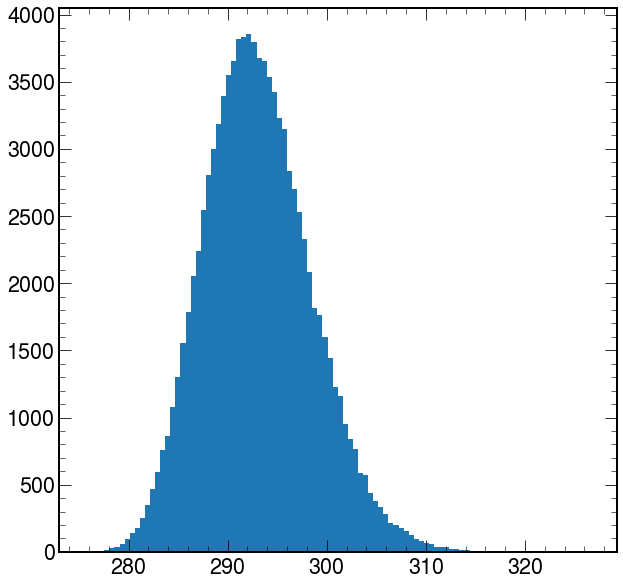

In [122]:
_ = plt.hist(toy_likes, bins=100)